In [303]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy
import operator
import numpy as np
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import imageio

# Suggestion Engine Prototype

Minimizing the distance between reality and goals

provide goals and current gym status and then get and implement route suggestions given by the engine

Contrast with a pure mathematical approach of minimizing the N-dimensional distance

## Methodology

- Each column will represent a field. 
- We will use 1 hot representation. 
- A gym will be a stacked collection of routes
- We can know the mean of any category by summing and dividing by the rows.
- The goals are stored the same way, so we can get the distance between each field

## How the array looks

- 0-5: Styles: [balance,toe-hooking,heel-hooking,finger-strength,powerful]
- 5-10: Techniques: [balance,toe-hooking,heel-hooking,finger-strength,powerful]
- 10-15: grade: [blue,pink,purple,green,yellow]
- 15-18: length: [short,medium,long]
- 18-23: R: [1,2,3,4,5]
- 23-28: I: [1,2,3,4,5]
- 28-33: C: [1,2,3,4,5]
- 33-38: Location: [wave-wall,barrel,roof,accordian,shield]


In [77]:
route_dictionary = {0:'balance',
                   1:'toe-hooking',
                   2:'heel-hooking',
                   3:'finger-strength',
                   4:'powerful',
                    
                   5:'balance',
                   6:'toe-hooking',
                   7:'heel-hooking',
                   8:'finger-strength',
                   9:'powerful',
                    
                    10:'blue',
                    11:'pink',
                    12:'purple',
                    13:'green',
                    14:'yellow',
                    
                    15:'short',
                    16:'medium',
                    17:'long',
                    
                    18:'1',
                    19:'2',
                    20:'3',
                    21:'4',
                    22:'5',
                    
                    23:'1',
                    24:'2',
                    25:'3',
                    26:'4',
                    27:'5',
                    
                    28:'1',
                    29:'2',
                    30:'3',
                    31:'4',
                    32:'5',
                    
                    33:'wave-wall',
                    34:'barrel',
                    35:'roof',
                    36:'accordian',
                    37:'shield'
                   }

array_dictionary = np.array(['balance','toe-hooking','heel-hooking','finger-strength','powerful',\
                    'balance','toe-hooking','heel-hooking','finger-strength','powerful',
                    'blue','pink','purple','green','yellow',
                     'short','medium','long',
                     '1','2','3','4','5',
                    '1','2','3','4','5',
                    '1','2','3','4','5',
                    'wave-wall','barrel','roof','accordian','shield'])

def convert_array_to_readable(array):
    mask = np.where(array > 0)[0]
    return array_dictionary[mask]

In [78]:
"""
Gen ints between 0-5,5-10,10-15,15-18,18-23,23-28,28-33,33-38

can gen multiple in a given category for instance multiple styles
"""

def gen_random_route(num_routes):
    routes = np.zeros((num_routes,38))
    for n in range(num_routes):
        style = np.random.choice(np.arange(0,5))
        technique = np.random.choice(np.arange(5,10))
        grade = np.random.choice(np.arange(10,15))
        length = np.random.choice(np.arange(15,18))
        R = np.random.choice(np.arange(18,23))
        I = np.random.choice(np.arange(23,28))
        C = np.random.choice(np.arange(28,33))
        Location = np.random.choice(np.arange(33,38))
        mask = np.array([style,technique,grade,length,R,I,C,Location])
        routes[n][mask] = 1
    return routes

In [102]:
def make_default_goals(num_routes):
    goals = np.zeros(38)
    by_5 = num_routes / 5
    by_3 = num_routes / 3
    styles = by_5
    techniques = by_5
    grades = by_5
    length = by_3
    R = by_5
    I = by_5
    C = by_5
    Location = by_5
    
    goals[0:5] = np.full(5,styles)
    goals[5:10] = np.full(5,techniques)
    goals[10:15] = np.full(5,grades)
    goals[15:18] = np.full(3,length)
    goals[18:23] = np.full(5,R)
    goals[23:28] = np.full(5,I)
    goals[28:33] = np.full(5,C)
    goals[33:38] = np.full(5,Location)
    return goals

def random_num(max_num,N):
    arr = np.zeros(N)
    arr[0] = np.random.random() * max_num
    max_num -= arr[0]
    for i in range(1,N-1):
        arr[i] = np.random.random() * max_num
        max_num -= arr[i]
    arr[-1] = max_num
    return arr

def gen_random_goals(num_routes):
    goals = np.zeros(38)
    
    styles = random_num(num_routes,5)
    techniques = random_num(num_routes,5)
    grades = random_num(num_routes,5)
    length = random_num(num_routes,3)
    R = random_num(num_routes,5)
    I = random_num(num_routes,5)
    C = random_num(num_routes,5)
    Location = random_num(num_routes,5)
    
    goals[0:5] = styles
    goals[5:10] = techniques
    goals[10:15] = grades
    goals[15:18] = length
    goals[18:23] = R
    goals[23:28] = I
    goals[28:33] = C
    goals[33:38] = Location
    return goals

## Test functions

In [173]:
# Test readable
# mask = np.array([1,6,11,16,20,24,32,35])

# arr_route = np.zeros(38)
# arr_route[mask] = 1
# readable_array = convert_array_to_readable(arr_route)
    
# Test ran gen
# ran_routes = gen_random_route(5)
# print('ran_routes',ran_routes.shape)
# readable_routes = [convert_array_to_readable(route) for route in ran_routes]
# print('readable_routes',readable_routes)

# test random num gen for goals
# styles = random_num(5,5)
# print('styles',styles,np.sum(styles))

# Test default goal gen
# goals = make_default_goals(5)
# print(goals)

# test random goals
# ran_goals = gen_random_goals(5)
# print('ran goals',ran_goals)

ran_routes (5, 38)
readable_routes [array(['powerful', 'balance', 'purple', 'long', '3', '5', '3',
       'wave-wall'], dtype='<U15'), array(['toe-hooking', 'heel-hooking', 'purple', 'medium', '4', '4', '4',
       'wave-wall'], dtype='<U15'), array(['finger-strength', 'powerful', 'pink', 'short', '5', '4', '5',
       'accordian'], dtype='<U15'), array(['finger-strength', 'balance', 'yellow', 'long', '4', '3', '1',
       'barrel'], dtype='<U15'), array(['toe-hooking', 'balance', 'blue', 'long', '3', '5', '3',
       'accordian'], dtype='<U15')]


## Gym class

To hold the current distribution of routes. And the goals of the gym, and return the L2 distance

In [451]:
class Gym(object):
    def __init__(self,routes,goals):
        self.routes = routes
        self.goals = goals
        self.index = 0
    
    def update_route(self,route):
        self.routes[self.index][:] = route
        self.index = (self.index + 1) % len(self)
        
    def get_route(self,index):
        return Gym.convert_array_to_readable(self.routes[index])
    
    @staticmethod
    def convert_array_to_readable(array):
        mask = np.where(array > 0)[0]
        return array_dictionary[mask]
    
    @property
    def get_index(self):
        return self.index
        
    @property
    def L2(self):
        # mean columns in routes
        current_dist = np.sum(self.routes,axis = 0)
        nd_distance = self.goals - current_dist
        return nd_distance
    
    @property
    def loss(self):
        current_dist = np.sum(self.routes,axis = 0)
        nd_distance = self.goals - current_dist
        return np.sum((nd_distance)**2)
    
    def __len__(self):
        # Return number of routes
        return self.routes.shape[0]

# Test Gym class

In [340]:
routes = gen_random_route(10)
goals = gen_random_goals(10)

elevation = Gym(routes,goals)

In [341]:
print('Goal shape',goals.shape)
print('routes shape',routes.shape)
print('Number of routes',len(elevation))
print('5th route',elevation.get_route(5))
print('distance',elevation.L2)
print('routes',np.sum(routes,axis=0))
print('goals',goals)

Goal shape (38,)
routes shape (10, 38)
Number of routes 10
5th route ['powerful' 'heel-hooking' 'green' 'medium' '2' '2' '4' 'barrel']
distance [-1.92175387  6.67798486  0.4654931  -1.43892114 -3.78280296  1.39248334
  0.65879648  0.22075695 -0.52028699 -1.75174978  3.64658353  1.11226916
  0.10244699 -3.9337989  -0.92750078 -5.70335287  4.1181058   1.58524707
 -0.77036648 -1.4836155   0.44494187  1.13993126  0.66910884 -1.85283069
 -3.80988824  1.44707053  6.15769796 -1.94204956  2.49650561  0.36880896
 -0.51847974 -5.7240647   3.37722987  0.01137718 -1.05463981 -0.60251574
  2.19994695 -0.55416858]
routes [4. 0. 0. 2. 4. 3. 1. 3. 1. 2. 1. 1. 3. 4. 1. 7. 1. 2. 8. 2. 0. 0. 0. 2.
 4. 0. 2. 2. 2. 0. 2. 6. 0. 1. 3. 3. 1. 2.]
goals [2.07824613 6.67798486 0.4654931  0.56107886 0.21719704 4.39248334
 1.65879648 3.22075695 0.47971301 0.24825022 4.64658353 2.11226916
 3.10244699 0.0662011  0.07249922 1.29664713 5.1181058  3.58524707
 7.22963352 0.5163845  0.44494187 1.13993126 0.66910884 0.147

# Network

In [384]:
class Network(nn.Module):
    def __init__(self,state_space,seed,hidden_dims=(32,32),activation_fc=F.relu):
        super(Network,self).__init__()
        self.activation_fc = activation_fc
        self.seed = torch.manual_seed(seed)
        self.input_layer = nn.Linear(state_space,hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i],hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        
        # Outputs, we softmax over the various classes for 1 per class (can change this for multi class)
        self.style = nn.Linear(hidden_dims[-1],5)
        self.techniques = nn.Linear(hidden_dims[-1],5)
        self.grades = nn.Linear(hidden_dims[-1],5)
        self.length = nn.Linear(hidden_dims[-1],3)
        self.R = nn.Linear(hidden_dims[-1],5)
        self.I = nn.Linear(hidden_dims[-1],5)
        self.C = nn.Linear(hidden_dims[-1],5)
        self.Location = nn.Linear(hidden_dims[-1],5)
        
    def forward(self,state):
        x = state
        if not isinstance(state,torch.Tensor):
            x = torch.tensor(x,dtype=torch.float32) #device = self.device,
            x = x.unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
            
        # Outputs
        S = F.softmax(self.style(x),dim=1)
        T = F.softmax(self.techniques(x),dim=1)
        G = F.softmax(self.grades(x),dim=1)
        L = F.softmax(self.length(x),dim=1)
        R = F.softmax(self.R(x),dim=1)
        I = F.softmax(self.I(x),dim=1)
        C = F.softmax(self.C(x),dim=1)
        Location = F.softmax(self.Location(x),dim=1)
        # Cat outputs
        route = torch.cat([S,T,G,L,R,I,C,Location],dim=1)
#         log_probs = torch.log(route)
        return route

In [366]:
state_space = 38
seed = 1234
suggestion_engine = Network(state_space,seed)
optimizer = optim.Adam(net.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

## Test network outputs

In [367]:
test_routes = gen_random_route(10)
output = suggestion_engine(test_routes[0]).squeeze(0)
# print('output[:5]',output.detach().cpu().numpy()[:5])
# print('output[5:10]',output.detach().cpu().numpy()[5:10])
print('output',output,output.shape)
# print('output[:5]',np.sum(output.detach().cpu().numpy()[:5]))
# print('output[5:10]',np.sum(output.detach().cpu().numpy()[5:10]))
print('distance',elevation.L2)
print('loss',elevation.loss)

output tensor([0.1913, 0.2065, 0.1836, 0.2040, 0.2146, 0.2273, 0.1598, 0.2165, 0.2143,
        0.1821, 0.2050, 0.2035, 0.1955, 0.1861, 0.2099, 0.3307, 0.3759, 0.2934,
        0.1899, 0.1915, 0.1882, 0.2274, 0.2030, 0.2220, 0.2137, 0.1957, 0.1898,
        0.1789, 0.1939, 0.1864, 0.2065, 0.1860, 0.2271, 0.2092, 0.2114, 0.1788,
        0.1921, 0.2086], grad_fn=<SqueezeBackward1>) torch.Size([38])
distance [-1.92175387  6.67798486  0.4654931  -1.43892114 -3.78280296  1.39248334
  0.65879648  0.22075695 -0.52028699 -1.75174978  3.64658353  1.11226916
  0.10244699 -3.9337989  -0.92750078 -5.70335287  4.1181058   1.58524707
 -0.77036648 -1.4836155   0.44494187  1.13993126  0.66910884 -1.85283069
 -3.80988824  1.44707053  6.15769796 -1.94204956  2.49650561  0.36880896
 -0.51847974 -5.7240647   3.37722987  0.01137718 -1.05463981 -0.60251574
  2.19994695 -0.55416858]
loss 7.3007308443645496


In [452]:
def route_from_suggestion(suggestion):
    route = np.zeros(38)
    
    styles = suggestion[0:5] 
    techniques     = suggestion[5:10] 
    grades     = suggestion[10:15] 
    length     = suggestion[15:18] 
    R     = suggestion[18:23] 
    I     = suggestion[23:28] 
    C     = suggestion[28:33] 
    Location     = suggestion[33:38] 
    
    values_5 = np.arange(5)
    values_3 = np.arange(3)
    
    route_style = np.random.choice(values_5,p=styles)
    route_techniques = np.random.choice(values_5,p=techniques) + 5
    route_grades = np.random.choice(values_5,p=grades) + 10
    route_length = np.random.choice(values_3,p=length) + 15
    route_R = np.random.choice(values_5,p=R) + 18
    route_I = np.random.choice(values_5,p=I) + 23
    route_C = np.random.choice(values_5,p=C) + 28
    route_Locations = np.random.choice(values_5,p=Location) + 33
    
    mask = np.array([route_style,route_techniques,route_grades,\
                           route_length,route_R,route_I,route_C,route_Locations])
#     print('mask',mask)
    route[mask] = 1
    return route

# Math create next route

For comparison

- minus means we need to get rid of
- plus means we need to boost occurances of

In [547]:
def route_from_distance(distance):
    route = np.zeros(38)
    
    styles = distance[0:5] 
    techniques     = distance[5:10] 
    grades     = distance[10:15] 
    length     = distance[15:18] 
    R     = distance[18:23] 
    I     = distance[23:28] 
    C     = distance[28:33] 
    location     = distance[33:38] 
    
    r_styles = np.where(styles == np.max(styles))[0]
    r_techniques = np.where(techniques == np.max(techniques))[0] + 5
    r_grades = np.where(grades == np.max(grades))[0] + 10
    r_length = np.where(length == np.max(length))[0] + 15
    r_R = np.where(R == np.max(R))[0] + 18
    r_I = np.where(I == np.max(I))[0] + 23
    r_C = np.where(C == np.max(C))[0] + 28
    r_location = np.where(location == np.max(location))[0] + 33
    
    mask = np.array([r_styles,r_techniques,r_grades,r_length,r_R,r_I,r_C,r_location])
#     print(mask)
    route[mask] = 1
    return route

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def probabilistic_route(distance):
    route = np.zeros(38)
    epsilon = 0
    arr_5 = np.arange(5)
    arr_3 = np.arange(3)
    
    styles = distance[0:5] 
    techniques     = distance[5:10] 
    grades     = distance[10:15] 
    length     = distance[15:18] 
    R     = distance[18:23] 
    I     = distance[23:28] 
    C     = distance[28:33] 
    location     = distance[33:38] 
    
    r_style_prob = softmax(styles+np.abs(np.min(styles))+epsilon)
    r_tech_prob = softmax(techniques+np.abs(np.min(techniques))+epsilon)
    r_grad_prob = softmax(grades+np.abs(np.min(grades))+epsilon)
    length_prob = softmax(length+np.abs(np.min(length))+epsilon)
    r_prob = softmax(R+np.abs(np.min(R))+epsilon)
    i_prob =softmax(I+np.abs(np.min(I))+epsilon)
    c_prob = softmax(C+np.abs(np.min(C))+epsilon)
    loc_prob = softmax(location+np.abs(np.min(location))+epsilon)
    
    r_styles = np.random.choice(arr_5,p=r_style_prob)
    r_techniques = np.random.choice(arr_5,p=r_tech_prob) + 5
    r_grades = np.random.choice(arr_5,p=r_grad_prob) + 10
    r_length = np.random.choice(arr_3,p=length_prob) + 15
    r_R = np.random.choice(arr_5,p=r_prob) + 18
    r_I = np.random.choice(arr_5,p=i_prob) + 23
    r_C = np.random.choice(arr_5,p=c_prob) + 28
    r_location = np.random.choice(arr_5,p=loc_prob) + 33
    
    mask = np.array([r_styles,r_techniques,r_grades,r_length,r_R,r_I,r_C,r_location])
#     print(mask)
    route[mask] = 1
    return route

In [548]:
# Test route_from_distance
# route_from_distance(elevation.L2)

In [549]:
def train(config):
    scores = []
    for e in range(config.episodes):
        episode_scores = []
        routes = gen_random_route(10)
        goals = gen_random_goals(10)
        elevation = Gym(routes,goals)
        print('starting loss',elevation.loss)
        for i in range(config.tmax):
            # Record loss and distance
            state = elevation.L2
            prev_loss = elevation.loss
            # Pass distance into math
#             route = route_from_distance(state)
            route = probabilistic_route(state)
            # Update gym
            elevation.update_route(route)
            # Get new loss
            loss = elevation.loss
            episode_scores.append(loss)
            print('loss',loss)
#             print('value of step',loss-prev_loss)
        print('end loss',loss)
        print('progress')
        scores.append(loss)
    return episode_scores

In [550]:
scores = train(config)

starting loss 379.1973329211085
loss 303.6669458198004
loss 225.00377815934243
loss 210.13738405128768
loss 141.96865844437605
loss 94.00633423012073
loss 62.3569208515146
loss 54.03783045428569
loss 40.30145023361909
loss 25.262553106269987
loss 26.100736539229683
loss 31.98879531984505
loss 44.55463573868661
loss 49.266514697861275
loss 55.90169937883924
loss 80.90869562399142
loss 66.13692813829809
loss 66.31020438503873
loss 71.45627771642866
loss 51.678584612780305
loss 42.114570925259784
loss 35.97675009125059
loss 28.96861516361055
loss 46.55240280402003
loss 53.559571465747396
loss 47.9031888491183
loss 52.926154418055155
loss 57.85698862146258
loss 56.699617502643704
loss 57.05240345793108
loss 43.8111460001139
loss 49.95256961923154
loss 33.68884279704303
loss 26.622650040744606
loss 37.68638415565829
loss 35.55330201365549
loss 52.05281178513276
loss 61.123030985444316
loss 63.13432877287325
loss 57.11080283793959
loss 76.8693633857552
loss 52.09048115429684
loss 70.15874551

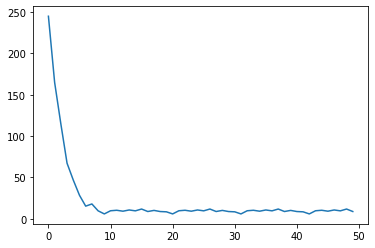

In [469]:
plt.plot(scores)

# Train the network

- Loss is the difference in loss between the previous route distribution and the current one.
- We want to increase/decrease the log probability of choosing that 'action/distribution' based on the loss difference.
- We update the log probs with the gradiant of the outcome


In [416]:
def train(policy,optimizer,config):
    scores = []
    for e in range(config.episodes):
        routes = gen_random_route(10)
        goals = gen_random_goals(10)
        elevation = Gym(routes,goals)
        print('starting loss',elevation.loss)
        for i in range(config.tmax):
#             current_dist = np.sum(elevation.routes,axis = 0)
#             nd_distance = elevation.goals - current_dist
#             prev_loss = np.mean((nd_distance)**2)
#             print('prev_loss',prev_loss)
            # Record loss and distance
            state = elevation.L2
            prev_loss = elevation.loss
#             print('prev_loss',prev_loss)
            # Pass distance into network
            suggestion = policy(state)
            # Get route from suggestion
            route = route_from_suggestion(suggestion.detach().cpu().squeeze(0).numpy())
            # Update gym
            elevation.update_route(route)
            
            
            # Get new loss
            loss = elevation.loss
            # Get improvement
            route_loss = -torch.from_numpy(np.array(loss - prev_loss))
            difference = (suggestion - torch.from_numpy(route).float())
#             log_probs = torch.log(suggestion)
            grad = (difference * route_loss).mean()
        
            
            optimizer.zero_grad()
            grad.backward()
            optimizer.step()
            print('grad',grad)
        print('end loss',loss)
        scores.append(loss)
    return policy,scores

In [417]:
class Config(object):
    def __init__(self,episodes,tmax):
        self.episodes = episodes
        self.tmax = tmax

In [460]:
episodes = 1
tmax = 50

config = Config(episodes,tmax)

In [ ]:
policy,scores = train(suggestion_engine,optimizer,config)

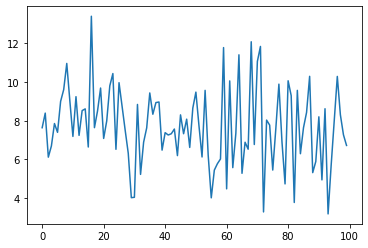

In [419]:
plt.plot(scores)